In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import math_ops
from ESN import EchoStateRNNCell
import matplotlib.pyplot as plt

# takes only current needed GPU memory
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# random numbers
random_seed = 1
rng = np.random.RandomState(random_seed)

We define a simple simulation with a single batch. A timeseries of 'stime' timesteps is run. The input is a inpulse 
given in the first timestep consisting of a gaussian noise given to each unit.

In [2]:
# Global variables
batches = 1
stime = 200
num_units = 100
init_state = np.zeros([batches, num_units], dtype="float32")
rnn_inputs = np.zeros((batches, stime, num_units), dtype="float32")
rnn_inputs[0, 0, :] = np.random.randn(num_units)*100
target = np.sin(np.linspace(0, 6*np.pi, stime)).astype("float32").reshape(stime,1)

trunk_tanh = lambda x: math_ops.maximum(0.0, math_ops.tanh(x))


Implementing a static graph without tensorflow API:

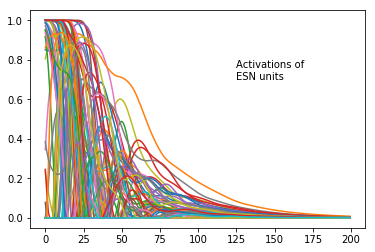

In [9]:

static_graph = tf.Graph()
with static_graph.as_default() as g:
        
    rng = np.random.RandomState(random_seed)

    # Init the ESN cell
    cell = EchoStateRNNCell(num_units=num_units, 
                            activation=trunk_tanh, 
                            decay=0.100, 
                            epsilon=1e-10,
                            alpha=0.300,
                            rng=rng)
    
    # Build the graph
    states = []
    prev_state = init_state
    for t in range(stime):
        out,prev_state = cell(inputs=rnn_inputs[0,t,:], state=prev_state)
        states.append(out)
    
    outputs = tf.reshape(states, [stime, num_units])

    # Run the simulation
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        curr_outputs = sess.run(outputs)
        plt.plot(np.squeeze(curr_outputs))
        plt.text(125, 0.7, "Activations of \nESN units")
        plt.show()

Implementing a dynamic graph using tensorflow API

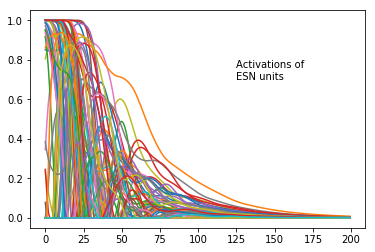

In [10]:
dynamic_graph = tf.Graph()
with dynamic_graph.as_default() as g:
    
    rng = np.random.RandomState(random_seed)

    # Init the ESN cell
    cell = EchoStateRNNCell(num_units=num_units, 
                            activation=trunk_tanh, 
                            decay=0.0100, 
                            epsilon=1e-40,
                            alpha=0.0100,
                            rng=rng)
    
    # Build the graph using the API
    states, final_state = tf.nn.dynamic_rnn(cell, 
                                            rnn_inputs, 
                                            initial_state=init_state)
    
    # tf.nn.dynamic_rnn returns the state, not the output of the cell
    outputs = tf.reshape(trunk_tanh(states), [stime, num_units])
     
    # Run the simulation
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
                 
        stored_outputs = sess.run(outputs)
                
        plt.plot(np.squeeze(curr_outputs))       
        plt.text(125, 0.7, "Activations of \nESN units")
        plt.show()
        

Run  a simple training on the outputs

step 49999, error 0.00228498643264


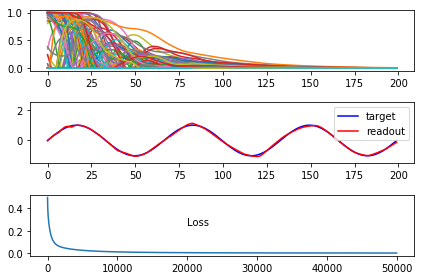

In [14]:
with dynamic_graph.as_default() as g: 
    rng = np.random.RandomState(random_seed)
    training_steps = 50000

    # the weights to the readout unit - to be trained with regularization
    regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)
    W_esn2out = tf.get_variable("W_esn2out", 
                                initializer=np.zeros([num_units, 1], dtype="float32"),
                                regularizer=regularizer)
    
    # readout activation
    readout = tf.matmul(stored_outputs, W_esn2out) 
    
    # regularization term
    reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)

    # train graph
    loss = tf.reduce_sum(tf.pow( target - readout, 2))/stime + reg_term
    train = tf.train.GradientDescentOptimizer(0.03).minimize(loss)
    
    # Run the simulation
    with tf.Session(config=config) as sess:
        tf.get_variable_scope().reuse_variables()
        sess.run(tf.global_variables_initializer())
        
        # training loop
        losses = np.zeros(training_steps)
        for step in range(training_steps):
            curr_readout, curr_loss, _  =  sess.run([readout, loss, train])
            losses[step] = curr_loss
        print("step {}, error {}".format(step, curr_loss))  

        plt.subplot(311)
        plt.plot(np.squeeze(curr_outputs))
        plt.subplot(312)
        target_line, = plt.plot(target, color="blue")
        readout_line, = plt.plot(curr_readout, color="red")
        plt.legend([target_line, readout_line], ['target', 'readout'])
        plt.ylim([-1.5, 2.5])
        plt.subplot(313)
        plt.plot(losses)
        plt.text(2e4, 0.25, "Loss")
        plt.tight_layout()
        plt.show()
        